In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.ao import sparsity
import torch.quantization as tq

In [2]:
from models import Model
model = Model()
model.qconfig = tq.get_default_qconfig()
print(model)

Model(
  (quant): QuantStub()
  (seq): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
  )
  (linear): Linear(in_features=16, out_features=16, bias=True)
  (dequant): DeQuantStub()
)


## Create sparsifier

In [3]:
sparsifier = sparsity.WeightNormSparsifier(model, config=None)
print(sparsifier)

WeightNormSparsifier (
	Module Group 0
	    module: Linear(in_features=16, out_features=16, bias=True)
	    path: linear
	    sparsity_level: 0.5
	    sparsity_pattern: (1, 4)
	    zeros_per_block: 4

	Module Group 1
	    module: Linear(in_features=16, out_features=16, bias=True)
	    path: seq.0
	    sparsity_level: 0.5
	    sparsity_pattern: (1, 4)
	    zeros_per_block: 4
)


## Create a scheduler

In [4]:
sl_lambdas = [
    (lambda epoch: (1.0 / (1.0 + np.exp(-(epoch / 10.0))) * 2 - 1.0)),
    (lambda epoch: (np.log10(epoch + 1.0) / 2.0 if epoch < 100 else 1.0))
]

scheduler = sparsity.LambdaSL(sparsifier, sl_lambdas)

### Scheduler profiles

Text(0.5, 1.0, 'Sparsity level Scheduling (target = 0.9)')

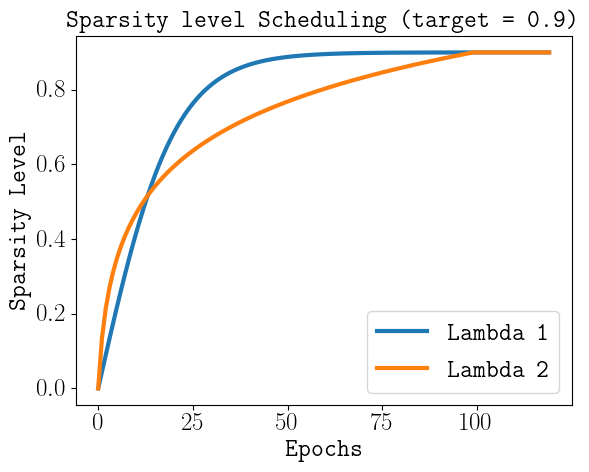

In [5]:
epochs = np.arange(120)
target_sparsity_level = 0.9
sl = [map(lmbda, epochs) for lmbda in sl_lambdas]

plt.plot(epochs, target_sparsity_level * np.array(list(sl[0])), label='Lambda 1')
plt.plot(epochs, target_sparsity_level * np.array(list(sl[1])), label='Lambda 2')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Sparsity Level')
plt.title(f'Sparsity level Scheduling (target = {target_sparsity_level})')

## Prepare

In [6]:
# Order matters, because the quantization mappings are not aware of the `ParametrizedLinear` =/= nn.Linear
tq.prepare(model, inplace=True)
sparsifier.prepare()
model

/home/zafar/Git/pytorch-dev/pytorch/torch/quantization/observer.py:134: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Model(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (seq): Sequential(
    (0): ParametrizedLinear(
      in_features=16, out_features=16, bias=True
      (activation_post_process): HistogramObserver()
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): MulBy()
        )
      )
    )
  )
  (linear): ParametrizedLinear(
    in_features=16, out_features=16, bias=True
    (activation_post_process): HistogramObserver()
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): MulBy()
      )
    )
  )
  (dequant): DeQuantStub()
)

## Step (or set some level of sparsity)

In [7]:
print(f'Sparsity before step: {1.0 - model.linear.mask.mean():.2%}')
print(f'Target sparsity level: {sparsifier.module_groups[0]["sparsity_level"]:.2%}')

# This is just to show the change in the scheduler
for epoch in range(10):
    # ... Training here
    sparsifier.step()
    scheduler.step()

print(f'Sparsity after step: {1.0 - model.linear.mask.mean():.2%}')
print(f'Target sparsity level: {sparsifier.module_groups[0]["sparsity_level"]:.2%}')

Sparsity before step: 0.00%
Target sparsity level: 0.00%
Sparsity after step: 21.88%
Target sparsity level: 23.11%


/home/zafar/Git/pytorch-dev/pytorch/torch/_tensor.py:557: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /home/zafar/Git/pytorch-dev/pytorch/aten/src/ATen/native/BinaryOps.cpp:461.)
  return torch.floor_divide(self, other)


## Calibrate

In [8]:
model(torch.randn(16, 16));

## Convert

In [9]:
print('=== BEFORE CONVERT ===')

print(f'Sparsity level (in the weight): {(model.seq[0].parametrizations.weight.original == 0).float().mean()}')
print(f'Sparsity level (in the weight): {(model.linear.parametrizations.weight.original == 0).float().mean()}')

print(f'Layer seq.0 has parametrizations: {hasattr(model.seq[0], "parametrizations")}')
print(f'Layer linear has parametrizations: {hasattr(model.linear, "parametrizations")}')
print(f'Layer seq.0 has mask: {hasattr(model.seq[0], "mask")}')
print(f'Layer linear has mask: {hasattr(model.linear, "mask")}')

=== BEFORE CONVERT ===
Sparsity level (in the weight): 0.0
Sparsity level (in the weight): 0.0
Layer seq.0 has parametrizations: True
Layer linear has parametrizations: True
Layer seq.0 has mask: True
Layer linear has mask: True


In [10]:
import torch.ao.nn.sparse.quantized as ao_qnn
from torch.ao.nn.sparse.quantized.utils import QNNPACKLinearBlockSparsePattern

# Order matters, as we want to fuse the mask BEFORE converting the layers into quantized
sparsifier.convert()

# We need to tell that the mappings are different now
sparse_mapping = tq.get_default_static_quant_module_mappings()
sparse_mapping[nn.Linear] = ao_qnn.Linear  # Also could be ao_nn.quantized.dynamic.Linear

# This is a stopgap measure until we figure out a better way
with QNNPACKLinearBlockSparsePattern(1, 4):
    tq.convert(model, inplace=True, mapping=sparse_mapping)

In [11]:
print('=== AFTER CONVERT ===')

print(f'Sparsity level (in the weight): {(model.seq[0].weight() == 0).float().mean()}')
print(f'Sparsity level (in the weight): {(model.linear.weight() == 0).float().mean()}')

print(f'Layer seq.0 has parametrizations: {hasattr(model.seq[0], "parametrizations")}')
print(f'Layer linear has parametrizations: {hasattr(model.linear, "parametrizations")}')
print(f'Layer seq.0 has mask: {hasattr(model.seq[0], "mask")}')
print(f'Layer linear has mask: {hasattr(model.linear, "mask")}')

=== AFTER CONVERT ===
Sparsity level (in the weight): 0.25390625
Sparsity level (in the weight): 0.22265625
Layer seq.0 has parametrizations: False
Layer linear has parametrizations: False
Layer seq.0 has mask: False
Layer linear has mask: False
